In [1]:
from collections import deque
from itertools import cycle
import numpy as np
from matplotlib import pyplot as plt
import torch

In [2]:
from environment import TicTacToeEnv
from agent import Agent

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
env = TicTacToeEnv()

In [5]:
X = Agent("X", state_size=env.size, action_size=env.size, device=device, seed=2022)
O = Agent("O", state_size=env.size, action_size=env.size, device=device, seed=2022)

In [6]:
env.add_players([X, O])

In [7]:
"""Deep Q-Learning.

Params
======
    n_episodes (int): maximum number of training episodes
    eps_start (float): starting value of epsilon, for epsilon-greedy action selection
    eps_end (float): minimum value of epsilon
    eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
"""
n_episodes = 100000
eps_start = 1.0
eps_end = 0.01
eps_decay = 1 / n_episodes

In [8]:
window = {X: deque([], maxlen=1000), O: deque([], maxlen=1000)}
mistakes = []
scores = {X: [], O: []}
eps = eps_start                    # initialize epsilon
mistake = 0
for i_episode in range(1, n_episodes + 1):
    state = env.reset()
    it = cycle([X, O])
    while True:
        player = next(it)
        action = player.act(state, eps)
        outcome, next_state = env.step(player, state, action)
        if outcome:
            break
        state = next_state * -1
    eps = max(eps_end, eps - eps_decay)  # decrease epsilon

    window[X].append(X.score)
    window[O].append(O.score)

    if outcome == "mistake":
        mistake += 1

    if i_episode % 1000 == 0:
        avg_x = np.mean(window[X])
        scores[X].append(avg_x)
        avg_o = np.mean(window[O])
        scores[O].append(avg_o)
        mistakes.append(mistake)
        print(f"\rEpisode {i_episode}\t X: {avg_x:.2f}\t O: {avg_o:.2f}\t Mistakes: {mistake} \teps: {eps:.2f}", end="")
        mistake = 0
print()
print(X, X.statistics)
print(O, O.statistics)

Episode 100000	 X: 0.11	 O: 0.02	 Mistakes: 4 	eps: 0.01067
X {'win': 46678, 'withdraw': 25805, 'mistake': 915}
O {'win': 25478, 'withdraw': 25805, 'mistake': 1124}


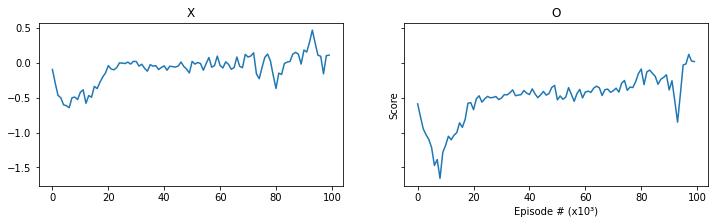

In [9]:
# plot the scores
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12,3))
ax1.plot(np.arange(len(scores[X])), scores[X])
ax2.plot(np.arange(len(scores[O])), scores[O])
ax1.set_title("X")
ax2.set_title("O")
plt.ylabel('Score')
plt.xlabel('Episode # (x10\u00b3)')
plt.show()

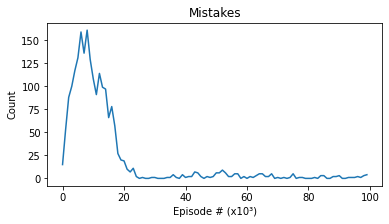

In [10]:
# plot the scores
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(np.arange(len(mistakes)), mistakes)
ax.set_title("Mistakes")
plt.ylabel('Count')
plt.xlabel('Episode # (x10\u00b3)')
plt.show()

In [11]:
torch.save(X.qnetwork_local.state_dict(), 'X.pth')
torch.save(O.qnetwork_local.state_dict(), 'O.pth')

In [12]:
env.close()